In [1]:
import pandas as pd
import numpy as np
import os
import glob
import spacy
import string
import pickle as pkl
from tqdm import tqdm_notebook
from nltk import ngrams
import random
from collections import Counter
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import json
%matplotlib inline

# Load Data

In [2]:
def build_data(data_dir):
    pospath = os.path.join(data_dir, 'pos', '*.txt')
    posfiles = glob.iglob(pospath)
    negpath = os.path.join(data_dir, 'neg', '*.txt')
    negfiles = glob.iglob(negpath)
    
    X = []
    y = []
    
    for file in posfiles:
        with open(file, 'r') as f:
            text = f.read()
        X += [text]
        y += [1]
        
    for file in negfiles:
        with open(file, 'r') as f:
            text = f.read()
        X += [text]
        y += [0]
    
    df = pd.DataFrame({'X': X, 'y': y})
    return df

In [3]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'aclimdb', 'train')
data = build_data(data_dir)

In [4]:
mask = np.array([1]*20000 + [0]*5000) == 1
np.random.shuffle(mask)

In [5]:
mask = np.array([1]*20000 + [0]*5000) == 1
np.random.shuffle(mask)

In [6]:
mask = np.array([1]*20000 + [0]*5000) == 1
np.random.shuffle(mask)

train = data[mask]
val = data[~mask]

In [7]:
data_dir = os.path.join(cwd, 'aclimdb', 'test')
test = build_data(data_dir)

In [8]:
# save targets
# y_train = train['y']
# y_val = val['y']
# y_test = test['y']

# y_train.to_csv('y_train.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

In [9]:
print ("Train dataset size is {}".format(train.shape[0]))
print ("Val dataset size is {}".format(val.shape[0]))
print ("Test dataset size is {}".format(test.shape[0]))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [1077]:
# train.to_csv('X_train.csv')
# val.to_csv('X_val.csv')
# test.to_csv('X_test.csv')

# Tokenize Data

In [19]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation                
                    
def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

def replace_numeric(parsed):
    return [token if not token.like_num else tokenizer("#")[0] for token in parsed]

def remove_stopwords(parsed):
    return [token for token in parsed if not token.is_stop]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for tokens in tqdm_notebook(
            tokenizer.pipe(dataset['X'],
                           disable=['parser', 'tagger', 'ner'],
                           batch_size=512, n_threads=1)):
        tokens = replace_numeric(tokens)
        tokens = remove_stopwords(tokens)
        tokens = lower_case_remove_punc(tokens)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [20]:
# df_copy = df.copy()
# y = []
# js = []
# for i, dforow in tqdm_notebook(df_orig_tokens.iterrows()):
#     found = False
#     for j, dfrow in df_copy.iterrows():
#         if dfrow['tokens'] == dforow['tokens']:
#             y += [dfrow['y']]
#             js += [j]
#             df_copy = df_copy.drop(j, axis=0)
#             found = True
#             break
#     if found == False:
#         y += [None]
#         js += [None]

In [21]:
# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val)
# pkl.dump(val_data_tokens, open("val_data_tokens_remove_stop_remove_num.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test)
# pkl.dump(test_data_tokens, open("test_data_tokens_remove_stop_remove_num.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train)
# pkl.dump(train_data_tokens, open("train_data_tokens_remove_stop_remove_num.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens_remove_stop_remove_num.p", "wb"))

Tokenizing val data



Tokenizing test data



Tokenizing train data


# Set Modeling Parameters

In [960]:
params = {'tokenization_scheme': 'remove_stop',
          'ngrams': 4,
          'vocab_size': 50000,
          'emb_dim': 10,
          'optimizer': 'adam',
          'learning_rate': [0.01],
          'annealing': False,
          'max_sent': 400}

# Load Saved Data

In [961]:
def load_saved_data(tokenization_scheme):
    if tokenization_scheme == 'keep_punc':
        suffix = '_keep_punc.p'
    elif tokenization_scheme == 'remove_num':
        suffix = '_remove_num.p'
    elif tokenization_scheme == 'remove_stop':
        suffix = '_remove_stop.p'
    elif tokenization_scheme == 'remove_stop_remove_num':
        suffix = '_remove_stop_remove_num.p'
    elif tokenization_scheme == 'remove_punc_lower':
        suffix = '.p'
        
    train_data_base = 'train_data_tokens'
    all_tokens_base = 'all_train_tokens'
    val_data_base = 'val_data_tokens'
    test_data_base = 'test_data_tokens'
    
    train_data_tokens = pkl.load(open(train_data_base + suffix, "rb"))
    all_train_tokens = pkl.load(open(all_tokens_base + suffix, "rb"))
    val_data_tokens = pkl.load(open(val_data_base + suffix, "rb"))
    test_data_tokens = pkl.load(open(test_data_base + suffix, "rb"))
    
    y_train = pd.read_csv('y_train.csv', header=None)
    y_val = pd.read_csv('y_val.csv', header=None)
    y_test = pd.read_csv('y_test.csv', header=None)
    
    return train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens, y_train, y_val, y_test

In [962]:
train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens, y_train, y_val, y_test = \
    load_saved_data(params['tokenization_scheme'])

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2510018


# Add ngrams

In [963]:
def add_ngrams(token_dataset, n, all_tokens=None):
    new_token_dataset = copy.deepcopy(token_dataset)
    new_all_tokens = copy.deepcopy(all_tokens)
    if n > 1:
        for sample, newsample in tqdm_notebook(zip(token_dataset, new_token_dataset)):
            
            for i in range(2, n+1):
                new_grams = list(ngrams(sample, i))
                newsample += new_grams
                
            if all_tokens is not None:
                new_all_tokens += new_grams
            
    return new_token_dataset, new_all_tokens

In [964]:
NGRAMS = params['ngrams']

train_data_tokens_ngram, all_train_tokens_ngram = add_ngrams(train_data_tokens, NGRAMS, all_train_tokens)
val_data_tokens_ngram, _ = add_ngrams(val_data_tokens, NGRAMS)
test_data_tokens_ngram, _ = add_ngrams(test_data_tokens, NGRAMS)

# Build Vocabulary

In [965]:
max_vocab_size = params['vocab_size']
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [966]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 38398 ; token coerces
Token coerces; token id 38398


In [967]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [968]:
train_data_indices = token2index_dataset(train_data_tokens_ngram)
val_data_indices = token2index_dataset(val_data_tokens_ngram)
test_data_indices = token2index_dataset(test_data_tokens_ngram)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


# PyTorch Dataset & Data loaders

In [969]:
MAX_SENTENCE_LENGTH = params['max_sent']

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        
        padded_vec = np.pad(
            np.array(token_idx), pad_width=((0,MAX_SENTENCE_LENGTH-len(token_idx))),
            mode="constant", constant_values=0)
        
        label = torch.tensor(self.target_list[key]).long()
        
        return {'X': padded_vec, 'y': label, 'len': len(token_idx)}


# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, y_train.values.tolist())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, y_val.values.tolist())
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_dataset = IMDBDataset(test_data_indices, y_test.values.tolist())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False)

# for i, batch in enumerate(train_loader):
#     print(batch['X'])
#     print(batch['y'])
#     if i > 2:
#         break

# Define BOW Model

In [970]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# Train Model

In [971]:
def save_results(params, best_val_acc, val_accs, train_accs, train_losses, prior_results=None):
    params['best_val_acc'] = best_val_acc
    params['val_accs_plot'] = [val_accs]
    params['train_accs_plot'] = [train_accs]
    params['train_losses_plot'] = [train_losses]
    df = pd.DataFrame(params)
    if prior_results is not None:
        df = pd.concat([prior_results, df], axis=0)
    df.to_csv('results.csv')
    return df

Epoch: [1/20], Step: [101/625], Validation Acc: 66.46
Epoch: [1/20], Step: [201/625], Validation Acc: 79.6
Epoch: [1/20], Step: [301/625], Validation Acc: 82.56
Epoch: [1/20], Step: [401/625], Validation Acc: 82.96
Epoch: [1/20], Step: [501/625], Validation Acc: 86.64
Epoch: [1/20], Step: [601/625], Validation Acc: 86.68
Epoch: [2/20], Step: [101/625], Validation Acc: 87.3
Epoch: [2/20], Step: [201/625], Validation Acc: 87.72
Epoch: [2/20], Step: [301/625], Validation Acc: 88.0
Epoch: [2/20], Step: [401/625], Validation Acc: 88.38
Epoch: [2/20], Step: [501/625], Validation Acc: 88.58
Epoch: [2/20], Step: [601/625], Validation Acc: 88.98
Epoch: [3/20], Step: [101/625], Validation Acc: 88.96
Epoch: [3/20], Step: [201/625], Validation Acc: 88.94
Epoch: [3/20], Step: [301/625], Validation Acc: 89.16
Epoch: [3/20], Step: [401/625], Validation Acc: 89.0
Epoch: [3/20], Step: [501/625], Validation Acc: 89.38
Epoch: [3/20], Step: [601/625], Validation Acc: 89.3
Epoch: [4/20], Step: [101/625], V

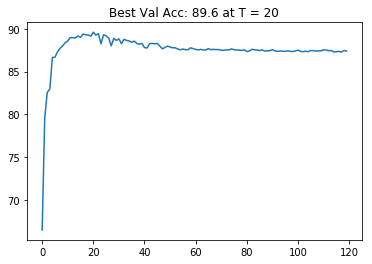

In [972]:
learning_rates = params['learning_rate']
num_epochs = 20 # number epoch to train
best_val_acc = 0

for learning_rate in learning_rates:
    # overwrite param for saving
    params['learning_rate'] = learning_rate
    
    #init model
    emb_dim = params['emb_dim']
    model = BagOfWords(len(id2token), emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss() 

    if params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        if params['annealing']:
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience=10)


    # Function for testing the model
    def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for batch in loader:
                data_batch = batch['X']
                label_batch = batch['y']
                length_batch = batch['len']
                outputs = F.softmax(model(data_batch, length_batch), dim=1)
                predicted = outputs.max(1, keepdim=True)[1]

                total += label_batch.size(0)
                correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
        return (100 * correct / total)

    train_accs = []
    train_losses = []
    val_accs = []
    for epoch in range(num_epochs):
        train_loss = 0
        samples_processed = 0
        for i, batch in enumerate(train_loader):
            model.train()
            data_batch = batch['X']
            label_batch = batch['y']
            length_batch = batch['len']
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.squeeze())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.sum().item()
            samples_processed += data_batch.size()[0]
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                val_accs += [val_acc]
                if params['annealing']:
                    scheduler.step(val_acc)

                if val_acc > best_val_acc:
                    best_model = copy.deepcopy(model)
                    best_val_acc = val_acc
                    
                train_acc = test_model(train_loader, model)
                train_accs += [train_acc]
                
                train_losses += [train_loss / samples_processed]

    plt.plot(val_accs)
    plt.title('Best Val Acc: {} at T = {}'.format(max(val_accs), np.argmax(val_accs)))

#     try:
#         results = pd.read_csv('results.csv', index_col=0)
#         results = results.reset_index(drop=True)
#     except:
#         results = None

#     results = save_results(params, max(val_accs), val_accs, train_accs, train_losses, results)

In [984]:
print ("After training for {} reporting steps".format(np.argmax(val_accs)))
print ("Val Acc {}".format(test_model(val_loader, best_model)))
print ("Test Acc {}".format(test_model(test_loader, best_model)))

After training for 20 reporting steps
Val Acc 89.6
Test Acc 87.816


# Analysis

In [973]:
results_final = pd.read_csv('results_final.csv', index_col=0)

In [974]:
results_final['val_accs_plot'] = list(map(lambda x: json.loads(x), results_final['val_accs_plot']))
results_final['train_accs_plot'] = list(map(lambda x: json.loads(x), results_final['train_accs_plot']))
results_final['train_losses_plot'] = list(map(lambda x: json.loads(x), results_final['train_losses_plot']))
results_final['best_train_acc'] = list(map(lambda x,y: y[np.argmax(x)] ,results_final['val_accs_plot'], results_final['train_accs_plot']))

In [976]:
results_final

,tokenization_scheme,ngrams,vocab_size,emb_dim,optimizer,learning_rate,annealing,max_sent,best_val_acc,val_accs_plot,train_accs_plot,train_losses_plot,best_train_acc
0,remove_punc_lower,1,10000,100,adam,0.0100,False,200,86.24,"[79.5, 82.9, 84.56, 84.54, 86.1, 86.2, 85.84, ...","[80.945, 86.025, 89.005, 89.79, 91.5, 92.275, ...","[0.018197324809314002, 0.015405780380934625, 0...",93.670
1,remove_num,1,10000,100,adam,0.0100,False,200,86.56,"[79.82, 83.76, 85.2, 85.56, 86.14, 86.3, 85.84...","[81.195, 86.65, 88.72, 90.57, 91.145, 91.995, ...","[0.01780421310796006, 0.014999278665830692, 0....",93.605
2,remove_stop,1,10000,100,adam,0.0100,False,200,87.56,"[83.5, 85.56, 85.58, 86.52, 87.54, 87.44, 87.5...","[84.85, 88.5, 89.58, 91.53, 93.225, 93.975, 94...","[0.016876873080756995, 0.013808730961893922, 0...",94.425
3,remove_stop_remove_num,1,10000,100,adam,0.0100,False,200,87.50,"[83.6, 85.4, 86.82, 86.78, 87.32, 87.5, 87.44,...","[85.275, 88.24, 90.745, 91.94, 93.09, 93.945, ...","[0.0173872285199785, 0.014075460435998678, 0.0...",93.945
4,remove_stop,1,20000,100,adam,0.0100,False,200,87.90,"[83.04, 85.42, 86.8, 87.02, 86.94, 87.9, 87.66...","[85.015, 89.6, 91.71, 93.19, 94.585, 95.85, 96...","[0.01637710521163622, 0.01353051406400862, 0.0...",95.850
5,remove_stop,1,30000,100,adam,0.0100,False,200,88.30,"[83.18, 85.18, 86.76, 87.38, 87.72, 88.06, 88....","[85.365, 89.52, 91.855, 93.63, 94.975, 96.185,...","[0.016713836811261602, 0.014105220190921234, 0...",96.935
6,remove_stop,1,40000,100,adam,0.0100,False,200,88.36,"[83.84, 85.72, 86.68, 86.9, 87.3, 88.36, 88.0,...","[85.64, 89.44, 91.935, 93.595, 94.85, 96.61, 9...","[0.01633716197592197, 0.013590128121628839, 0....",96.610
7,remove_stop,1,50000,100,adam,0.0100,False,200,88.48,"[82.94, 86.06, 87.12, 87.4, 87.86, 88.06, 88.4...","[85.255, 89.415, 92.08, 93.575, 95.225, 96.57,...","[0.016085969883542838, 0.013437374501920013, 0...",97.425
8,remove_stop,1,100000,100,adam,0.0100,False,200,88.32,"[82.12, 86.06, 86.66, 87.76, 87.88, 88.32, 88....","[83.955, 89.74, 92.11, 94.115, 95.44, 97.03, 9...","[0.016859431751072407, 0.013832601924792897, 0...",97.030
9,remove_stop,2,10000,100,adam,0.0100,False,200,88.48,"[79.66, 85.48, 87.04, 87.62, 88.0, 88.14, 88.4...","[80.7, 87.145, 90.095, 91.845, 92.9, 93.74, 94...","[0.01925493112885126, 0.015822136749175205, 0....",94.375


[Text(0,0,''),
 Text(0,0,'remove_punc_lower'),
 Text(0,0,''),
 Text(0,0,'remove_num'),
 Text(0,0,''),
 Text(0,0,'remove_stop'),
 Text(0,0,''),
 Text(0,0,'remove_stop_remove_num'),
 Text(0,0,'')]

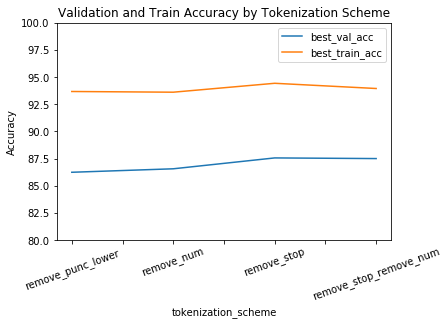

In [1049]:
ax = results_final.iloc[[0,1,2,3]].set_index('tokenization_scheme')[['best_val_acc', 'best_train_acc']].\
plot(ylim=[80, 100], title = "Validation and Train Accuracy by Tokenization Scheme", rot=20)
ax.set_ylabel('Accuracy')
ax.set_xticklabels(['','remove_punc_lower','','remove_num','','remove_stop','', 'remove_stop_remove_num',''])

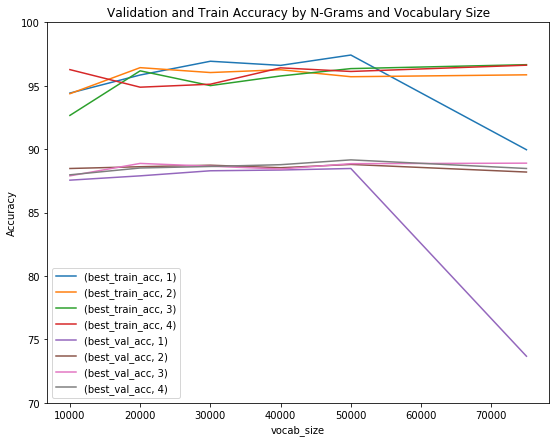

In [1048]:
ngram_vocab = results_final.loc[[2] + [x for x in range(4,30)]][['ngrams','vocab_size','best_val_acc', 'best_train_acc']]
ngram_vocab = ngram_vocab[ngram_vocab['vocab_size']<100000]

fig, ax = plt.subplots(figsize=(9,7))
pd.pivot_table(ngram_vocab, columns=['ngrams'], index=['vocab_size']).\
plot(ax=ax, ylim=[70, 100], title = "Validation and Train Accuracy by N-Grams and Vocabulary Size")
ax.set_ylabel('Accuracy')
plt.legend(loc=3)

Text(0,0.5,'Accuracy')

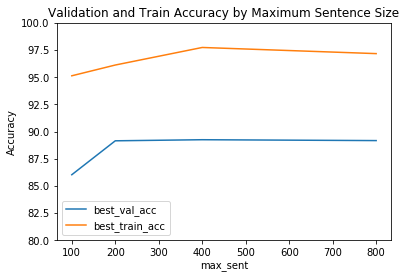

In [1047]:
ax = results_final.iloc[[27,30,31,32]].sort_values('max_sent').set_index('max_sent')[['best_val_acc', 'best_train_acc']].\
plot(ylim=[80, 100], title = "Validation and Train Accuracy by Maximum Sentence Size")
ax.set_ylabel('Accuracy')

Text(0,0.5,'Accuracy')

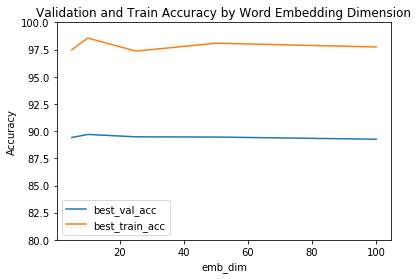

In [1046]:
ax = results_final.iloc[[31,33,34,35,36]].sort_values('emb_dim').set_index('emb_dim')[['best_val_acc', 'best_train_acc']].\
plot(ylim=[80, 100], title = "Validation and Train Accuracy by Word Embedding Dimension")
ax.set_ylabel('Accuracy')

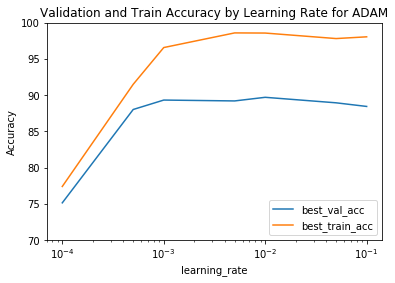

In [1058]:
ax = results_final.iloc[[35,37,38,39,40,41,42]].sort_values('learning_rate').set_index('learning_rate')[['best_val_acc', 'best_train_acc']].\
plot(ylim=[70, 100], title = "Validation and Train Accuracy by Learning Rate for ADAM")
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

Text(0,0.5,'Accuracy')

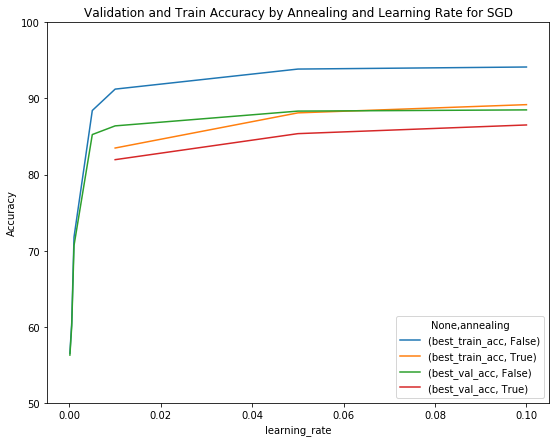

In [1067]:
anneal_sgd = results_final.loc[[x for x in range(43,53)]][['annealing','learning_rate','best_val_acc', 'best_train_acc']]

fig, ax = plt.subplots(figsize=(9,7))
pd.pivot_table(anneal_sgd, columns=['annealing'], index=['learning_rate']).\
plot(ax=ax, ylim=[50, 100], title = "Validation and Train Accuracy by Annealing and Learning Rate for SGD")
ax.set_ylabel('Accuracy')
# ax.set_xscale('log')


In [1072]:
val_analysis_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                  batch_size=1,
                                                  shuffle=False)

In [1073]:
def correct_incorrect_examples(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = []
    incorrect = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(loader):
            data_batch = batch['X']
            label_batch = batch['y']
            length_batch = batch['len']
            outputs = F.softmax(model(data_batch, length_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            if predicted.eq(label_batch.view_as(predicted)):
                correct += [i]
            else:
                incorrect += [i]

    return correct, incorrect

In [1074]:
correct, incorrect = correct_incorrect_examples(val_analysis_loader, best_model)

In [1106]:
index = correct[4474]
val.iloc[index]['X']

"This must be one of the worst Swedish movies ever made. <br /><br />It is embarrassing that such a bad script was allowed to become a movie and shown in cinemas as recently as year 2006.<br /><br />I've never seen so many visible sponsored products in one and the same movie. It shouldn't be that obvious. <br /><br />I can't understand why so many known actors even thought the idea to even be visible in a movie like this. If I had any respect for some of the known actors in this movie before I saw the movie, it is gone for sure now. <br /><br />I've heard that there will be a follow up movie to this one and I can't understand how that is even possible."

In [1107]:
val.iloc[index]['y']

0

In [1125]:
index = incorrect[519]
val.iloc[index]['X']

'Richard Farnsworth is one of my favorite actors. He usually gives solid performances, such as in The Straight Story, and The Grey Fox. He also does fairly well here, but the rest of the film suffers from a low budget, poor writing, and so-so photography. The Miller-Movie formula gives it a 4. Richard gets a 5.'

In [1126]:
val.iloc[index]['y']

0